In [1]:
import os

os.environ['TRKXINPUTDIR']="/global/cfs/projectdirs/atlas/xju/heptrkx/trackml_inputs/train_all"
os.environ['TRKXOUTPUTDIR']= "/global/cfs/projectdirs/m3443/usr/caditi97/iml2020/layerless_check/n1"

In [2]:
import pkg_resources
import yaml
import pprint
import random
random.seed(1234)
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import tqdm
from os import listdir
from os.path import isfile, join
import matplotlib.cm as cm
import sys
# %matplotlib widget

sys.path.append('/global/homes/c/caditi97/exatrkx-iml2020/exatrkx/src/')

# 3rd party
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from trackml.dataset import load_event
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint


# local import
from exatrkx import config_dict # for accessing predefined configuration files
from exatrkx import outdir_dict # for accessing predefined output directories
from exatrkx.src import utils_dir
from exatrkx.src import utils_robust
from utils_robust import *


# for preprocessing
from exatrkx import FeatureStore
from exatrkx.src import utils_torch

# for embedding
from exatrkx import LayerlessEmbedding
from exatrkx.src import utils_torch
from torch_cluster import radius_graph
from utils_torch import build_edges
from embedding.embedding_base import *

# for filtering
from exatrkx import VanillaFilter

# for GNN
import tensorflow as tf
from graph_nets import utils_tf
from exatrkx import SegmentClassifier
import sonnet as snt

# for labeling
from exatrkx.scripts.tracks_from_gnn import prepare as prepare_labeling
from exatrkx.scripts.tracks_from_gnn import clustering as dbscan_clustering

# track efficiency
from trackml.score import _analyze_tracks
from exatrkx.scripts.eval_reco_trkx import make_cmp_plot, pt_configs, eta_configs
from functools import partial

In [3]:
embed_ckpt_dir = '/global/cfs/cdirs/m3443/data/lightning_models/embedding/checkpoints/epoch=10.ckpt'
filter_ckpt_dir = '/global/cfs/cdirs/m3443/data/lightning_models/filtering/checkpoints/epoch=92.ckpt'
gnn_ckpt_dir = '/global/cfs/cdirs/m3443/data/lightning_models/gnn'
ckpt_idx = -1 # which GNN checkpoint to load
dbscan_epsilon, dbscan_minsamples = 0.25, 2 # hyperparameters for DBScan
min_hits = 5 # minimum number of hits associated with a particle to define "reconstructable particles"
frac_reco_matched, frac_truth_matched = 0.5, 0.5 # parameters for track matching
noise_keep = ["0", "0.2", "0.4", "0.6", "0.8", "1"]
evtid=1000

In [4]:
def plot_noise_dist(noise_keeps):
    noise = []
    not_noise = []
    for i in noise_keeps:
        data_path = f"/global/cfs/projectdirs/m3443/usr/caditi97/iml2020/layerless_check/n{i}/feature_store/1556"
        #data = torch.load(f"/global/cfs/projectdirs/m3443/usr/caditi97/iml2020/feature_store_endcaps/n{i}/1000")
        data = torch.load(data_path)
        arr = data['pid']
        n_count = np.count_nonzero(arr==0)
        not_n = np.count_nonzero(arr)
        noise.append(n_count)
        not_noise.append(not_n)
        print("-----")
        print(data)

    x = np.arange(len(noise_keeps))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(10,5))
    rects1 = ax.bar(x - width/2, noise, width, label='noise')
    rects2 = ax.bar(x + width/2, not_noise, width, label='not noise')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('# of hits')
    ax.set_xlabel('keep')
    ax.set_xticks(x)
    labels = noise_keeps
    ax.set_xticklabels(labels)
    ax.legend()
    
    fig2, ax2 = plt.subplots(figsize=(10,5))
    ax2.plot(x,noise, label='noise')
    ax2.set_ylabel('# of hits')
    ax2.set_xlabel('keep')
    ax2.set_xticks(x)
    labels = noise_keeps
    ax2.set_xticklabels(labels)
    ax2.legend()
    
    fig3, ax3 = plt.subplots(figsize=(10,5))
    ax3.plot(x,not_noise, label='not noise')
    ax3.set_ylabel('# of hits')
    ax3.set_xlabel('keep')
    ax3.set_xticks(x)
    labels = noise_keeps
    ax3.set_xticklabels(labels)
    ax3.legend()

-----
Data(cell_data=[101386, 9], event_file="/global/cfs/projectdirs/atlas/xju/heptrkx/trackml_inputs/train_all/event000001556", hid=[101386], layerless_true_edges=[2, 121281], layers=[101386], pid=[101386], x=[101386, 3])
-----
Data(cell_data=[104970, 9], event_file="/global/cfs/projectdirs/atlas/xju/heptrkx/trackml_inputs/train_all/event000001556", hid=[104970], layerless_true_edges=[2, 121281], layers=[101386], pid=[104970], x=[104970, 3])
-----
Data(cell_data=[108554, 9], event_file="/global/cfs/projectdirs/atlas/xju/heptrkx/trackml_inputs/train_100_events/event000001556", hid=[108554], layerless_true_edges=[2, 121281], layers=[101386], pid=[108554], x=[108554, 3])
-----
Data(cell_data=[112139, 9], event_file="/global/cfs/projectdirs/atlas/xju/heptrkx/trackml_inputs/train_100_events/event000001556", hid=[112139], layerless_true_edges=[2, 121281], layers=[101386], pid=[112139], x=[112139, 3])
-----
Data(cell_data=[115723, 9], event_file="/global/cfs/projectdirs/atlas/xju/heptrkx/tr

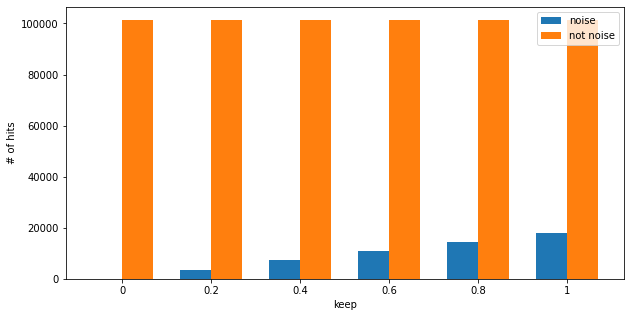

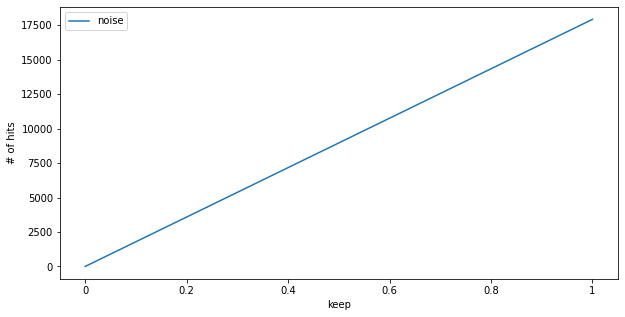

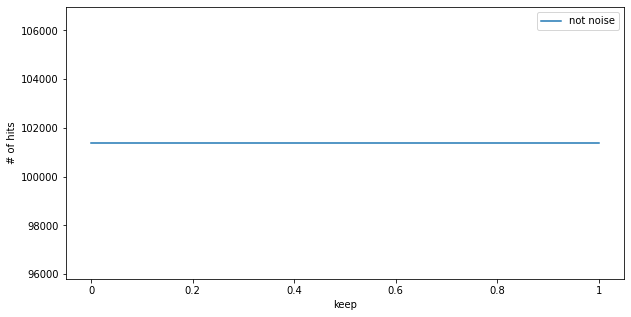

In [5]:
noise_keep = ["0", "0.2", "0.4", "0.6", "0.8", "1"]
#  "0.4", "0.6", "0.8", "1"
plot_noise_dist(noise_keep)

In [6]:
def calc_evts(noise_dir):
    data = torch.load(noise_dir)
    e_spatial = emb_eval(embed_ckpt_dir,data)
    output, f_model = filtering(filter_ckpt_dir,data,e_spatial)
    predict_tracks = build_graph(output, f_model,data, e_spatial, gnn_ckpt_dir,ckpt_idx,dbscan_epsilon, dbscan_minsamples)
    evt_path = data.event_file
    m_idx, pt, p_pt = track_eff(evt_path, predict_tracks,min_hits,frac_reco_matched, frac_truth_matched)
    return m_idx, pt, p_pt 

In [7]:
%%time
m0, p0, pp0 = calc_evts("/global/cfs/projectdirs/m3443/usr/caditi97/iml2020/layerless_check/n0/feature_store/1556")

 APPLYING GNN.....
Loaded -1 checkpoint from /global/cfs/cdirs/m3443/data/lightning_models/gnn
TRACK LABELLING.....


/global/homes/c/caditi97/.local/lib/python3.7/site-packages/sklearn/neighbors/_base.py:168: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  EfficiencyWarning)


----------
Processed 0 events from /global/cfs/projectdirs/atlas/xju/heptrkx/trackml_inputs/train_all
Reconstructable tracks:         8749
Reconstructed tracks:           13504
Reconstructable tracks Matched: 8005
Tracking efficiency:            0.9150
Tracking purity:               0.5928
CPU times: user 23min 11s, sys: 5min 57s, total: 29min 9s
Wall time: 1min 59s


In [8]:
%%time
m02, p02, pp02 = calc_evts("/global/cfs/projectdirs/m3443/usr/caditi97/iml2020/layerless_check/n0.2/feature_store/1556")

 APPLYING GNN.....
Loaded -1 checkpoint from /global/cfs/cdirs/m3443/data/lightning_models/gnn
TRACK LABELLING.....


/global/homes/c/caditi97/.local/lib/python3.7/site-packages/sklearn/neighbors/_base.py:168: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  EfficiencyWarning)


----------
Processed 0 events from /global/cfs/projectdirs/atlas/xju/heptrkx/trackml_inputs/train_all
Reconstructable tracks:         8749
Reconstructed tracks:           13749
Reconstructable tracks Matched: 7969
Tracking efficiency:            0.9108
Tracking purity:               0.5796
CPU times: user 26min 5s, sys: 6min 25s, total: 32min 30s
Wall time: 1min 59s


In [9]:
%%time
m04, p04, pp04 = calc_evts("/global/cfs/projectdirs/m3443/usr/caditi97/iml2020/layerless_check/n0.4/feature_store/1556")

 APPLYING GNN.....
Loaded -1 checkpoint from /global/cfs/cdirs/m3443/data/lightning_models/gnn
TRACK LABELLING.....


/global/homes/c/caditi97/.local/lib/python3.7/site-packages/sklearn/neighbors/_base.py:168: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  EfficiencyWarning)


----------
Processed 0 events from /global/cfs/projectdirs/atlas/xju/heptrkx/trackml_inputs/train_all
Reconstructable tracks:         8749
Reconstructed tracks:           14015
Reconstructable tracks Matched: 7956
Tracking efficiency:            0.9094
Tracking purity:               0.5677
CPU times: user 27min 31s, sys: 6min 56s, total: 34min 27s
Wall time: 2min 8s


In [10]:
%%time
m06, p06, pp06 = calc_evts("/global/cfs/projectdirs/m3443/usr/caditi97/iml2020/layerless_check/n0.6/feature_store/1556")

 APPLYING GNN.....
Loaded -1 checkpoint from /global/cfs/cdirs/m3443/data/lightning_models/gnn
TRACK LABELLING.....


/global/homes/c/caditi97/.local/lib/python3.7/site-packages/sklearn/neighbors/_base.py:168: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  EfficiencyWarning)


----------
Processed 0 events from /global/cfs/projectdirs/atlas/xju/heptrkx/trackml_inputs/train_all
Reconstructable tracks:         8749
Reconstructed tracks:           14157
Reconstructable tracks Matched: 7912
Tracking efficiency:            0.9043
Tracking purity:               0.5589
CPU times: user 30min 17s, sys: 7min 26s, total: 37min 44s
Wall time: 2min 15s


In [11]:
%%time
m08, p08, pp08 = calc_evts("/global/cfs/projectdirs/m3443/usr/caditi97/iml2020/layerless_check/n0.8/feature_store/1556")

 APPLYING GNN.....
Loaded -1 checkpoint from /global/cfs/cdirs/m3443/data/lightning_models/gnn
TRACK LABELLING.....


/global/homes/c/caditi97/.local/lib/python3.7/site-packages/sklearn/neighbors/_base.py:168: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  EfficiencyWarning)


----------
Processed 0 events from /global/cfs/projectdirs/atlas/xju/heptrkx/trackml_inputs/train_all
Reconstructable tracks:         8749
Reconstructed tracks:           14416
Reconstructable tracks Matched: 7893
Tracking efficiency:            0.9022
Tracking purity:               0.5475
CPU times: user 30min 23s, sys: 7min 55s, total: 38min 19s
Wall time: 2min 32s


In [12]:
%%time
m1, p1, pp1 = calc_evts("/global/cfs/projectdirs/m3443/usr/caditi97/iml2020/layerless_check/n1/feature_store/1556")

 APPLYING GNN.....
Loaded -1 checkpoint from /global/cfs/cdirs/m3443/data/lightning_models/gnn
TRACK LABELLING.....


/global/homes/c/caditi97/.local/lib/python3.7/site-packages/sklearn/neighbors/_base.py:168: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  EfficiencyWarning)


----------
Processed 0 events from /global/cfs/projectdirs/atlas/xju/heptrkx/trackml_inputs/train_all
Reconstructable tracks:         8749
Reconstructed tracks:           14600
Reconstructable tracks Matched: 7866
Tracking efficiency:            0.8991
Tracking purity:               0.5388
CPU times: user 32min 41s, sys: 8min 24s, total: 41min 6s
Wall time: 2min 39s


In [13]:
import math
def get_ratio(x_vals, y_vals):
    res = [x/y if y!=0 else 0.0 for x,y in zip(x_vals, y_vals)]
    err = [x/y * math.sqrt((x+y)/(x*y)) if y!=0 and x!=0 else 0.0 for x,y in zip(x_vals, y_vals)]
    return res[1:], err[1:]

In [14]:
def pairwise(iterable):
  """s -> (s0,s1), (s1,s2), (s2, s3), ..."""
  a, b = itertools.tee(iterable)
  next(b, None)
  return zip(a, b)

In [15]:
# _, ax1 = plt.subplots(figsize=(6,6))
# m_vals, bins, _ = ax1.hist(pp0[m0], **pt_configs, label="Matched")
# n_vals, _, _ = ax1.hist(pp0, **pt_configs, label="Reconstructable")
# ax1.set_xlabel("pT [GeV]")
# ax1.set_ylabel("Events")
# plt.legend()

In [16]:
def get_bins(x,y, config):
    _, ax = plt.subplots(figsize=(6,6))
    m_vals, bins, _ = ax.hist(x, **config, label="Matched")
    n_vals, _, _ = ax.hist(y, **config, label="Reconstructable")
    return m_vals,bins,n_vals

In [17]:
def get_vals(m_vals,bins,n_vals):
    ratio, ratio_err = get_ratio(m_vals, n_vals)
    xvals = [0.5*(x[1]+x[0]) for x in pairwise(bins)][1:]
    xerrs = [0.5*(x[1]-x[0]) for x in pairwise(bins)][1:]
    return xvals,xerrs,ratio

In [18]:
def plot_vals(ax,x,y,config,n,xlabel="pT [GeV]"):
    m_vals,bins,n_vals = get_bins(x,y, config)
    xvals,xerrs,ratio = get_vals(m_vals,bins,n_vals)
    ax.errorbar(xvals, ratio, yerr=ratio_err, fmt='o', xerr=xerrs, lw=2)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Track efficiency')
    ax.set_yticks(np.arange(0.5, 1.05, step=0.05))
    ax.set_ylim(0.5, 1.05)
    plt.grid(True)

NameError: name 'ratio_err' is not defined

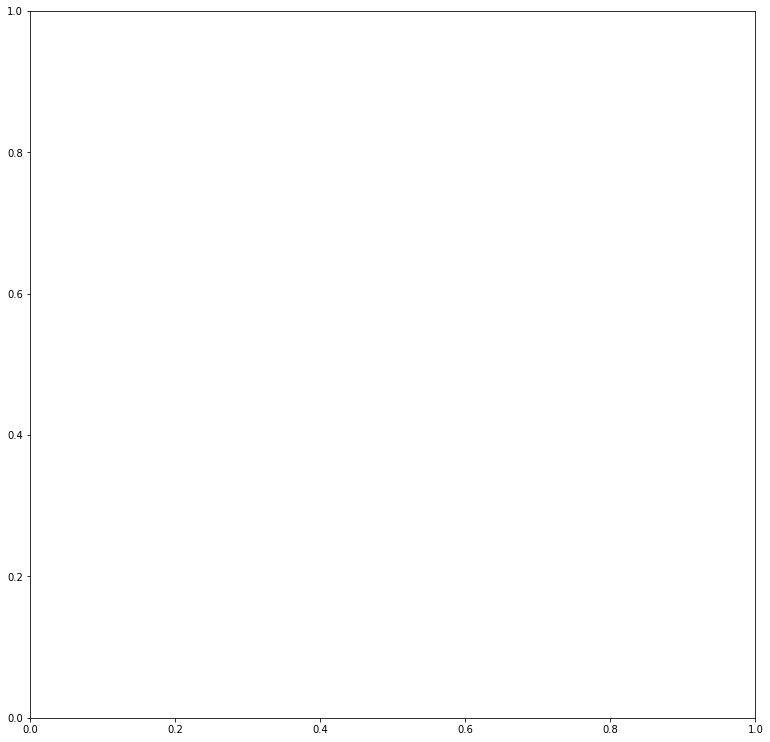

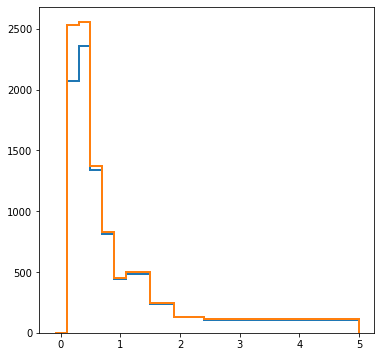

In [19]:
fig, ax2 = plt.subplots(figsize=(13,13))

plot_vals(ax2,pp0[m0],pp0,pt_configs,'0')
plot_vals(ax2,pp02[m02],pp02,pt_configs,'0.2')
plot_vals(ax2,pp04[m04],pp04,pt_configs,'0.4')
plot_vals(ax2,pp06[m06],pp06,pt_configs,'0.6')
plot_vals(ax2,pp08[m08],pp08,pt_configs,'0.8')
plot_vals(ax2,pp1[m1],pp1,pt_configs,'1')

plt.legend()
plt.show()

In [ ]:
# _, ax3 = plt.subplots(figsize=(13,13))

# plot_vals(ax3,p0[m0],p0,eta_configs,'0',r"$\eta$")
# plot_vals(ax3,p02[m02],p02,eta_configs,'0.2',r"$\eta$")
# plot_vals(ax3,p04[m04],p04,eta_configs,'0.4',r"$\eta$")
# plot_vals(ax3,p06[m06],p06,eta_configs,'0.6',r"$\eta$")
# plot_vals(ax3,p08[m08],p08,eta_configs,'0.8',r"$\eta$")
# plot_vals(ax3,p1[m1],p1,eta_configs,'1',r"$\eta$")
